In [1]:
###########################################################################################################################################Part of the code was taken from Michael Freeman https://github.com/mkfreeman/hierarchical-models/
##############################################################################################################require(lme4)
require(ggplot2)


Loading required package: lme4

Loading required package: Matrix

Loading required package: ggplot2



In [2]:
data = read.csv("data.csv", sep='')
data = data[data$response == "upper",]
data$encoding = as.character(data$encoding)#R convert strings to factor

# Illustrating the concept of random effects

As for the linear model (with only fixed effect) as seen up to now, we will still work on aggregated data for clarity. Additionally we will only use the easiness factor and 5 participants for this notebook

In [3]:
light_data = data[(data$participant < 6) & (data$encoding == "standard"),]#Using data for only 5 participants and the standard encoding condition
light_data$participant = as.character(light_data$participant)

In [4]:
means_bysub = aggregate(light_data$rt, FUN=mean, 
          by=list(ease=light_data$ease, participant = light_data$participant))
means_bysub$ease = means_bysub$ease-3#Same coding as before

### A model with random effects on the intercept

Recall that the previous notebook showed a linear model where only one slope was computed, the assumption is then that all participants have the same intercept and the same effect.

In [5]:
m1 <- lmer(x ~ ease + (1|participant), data = means_bysub)
means_bysub$random.intercept.preds <- predict(m1)

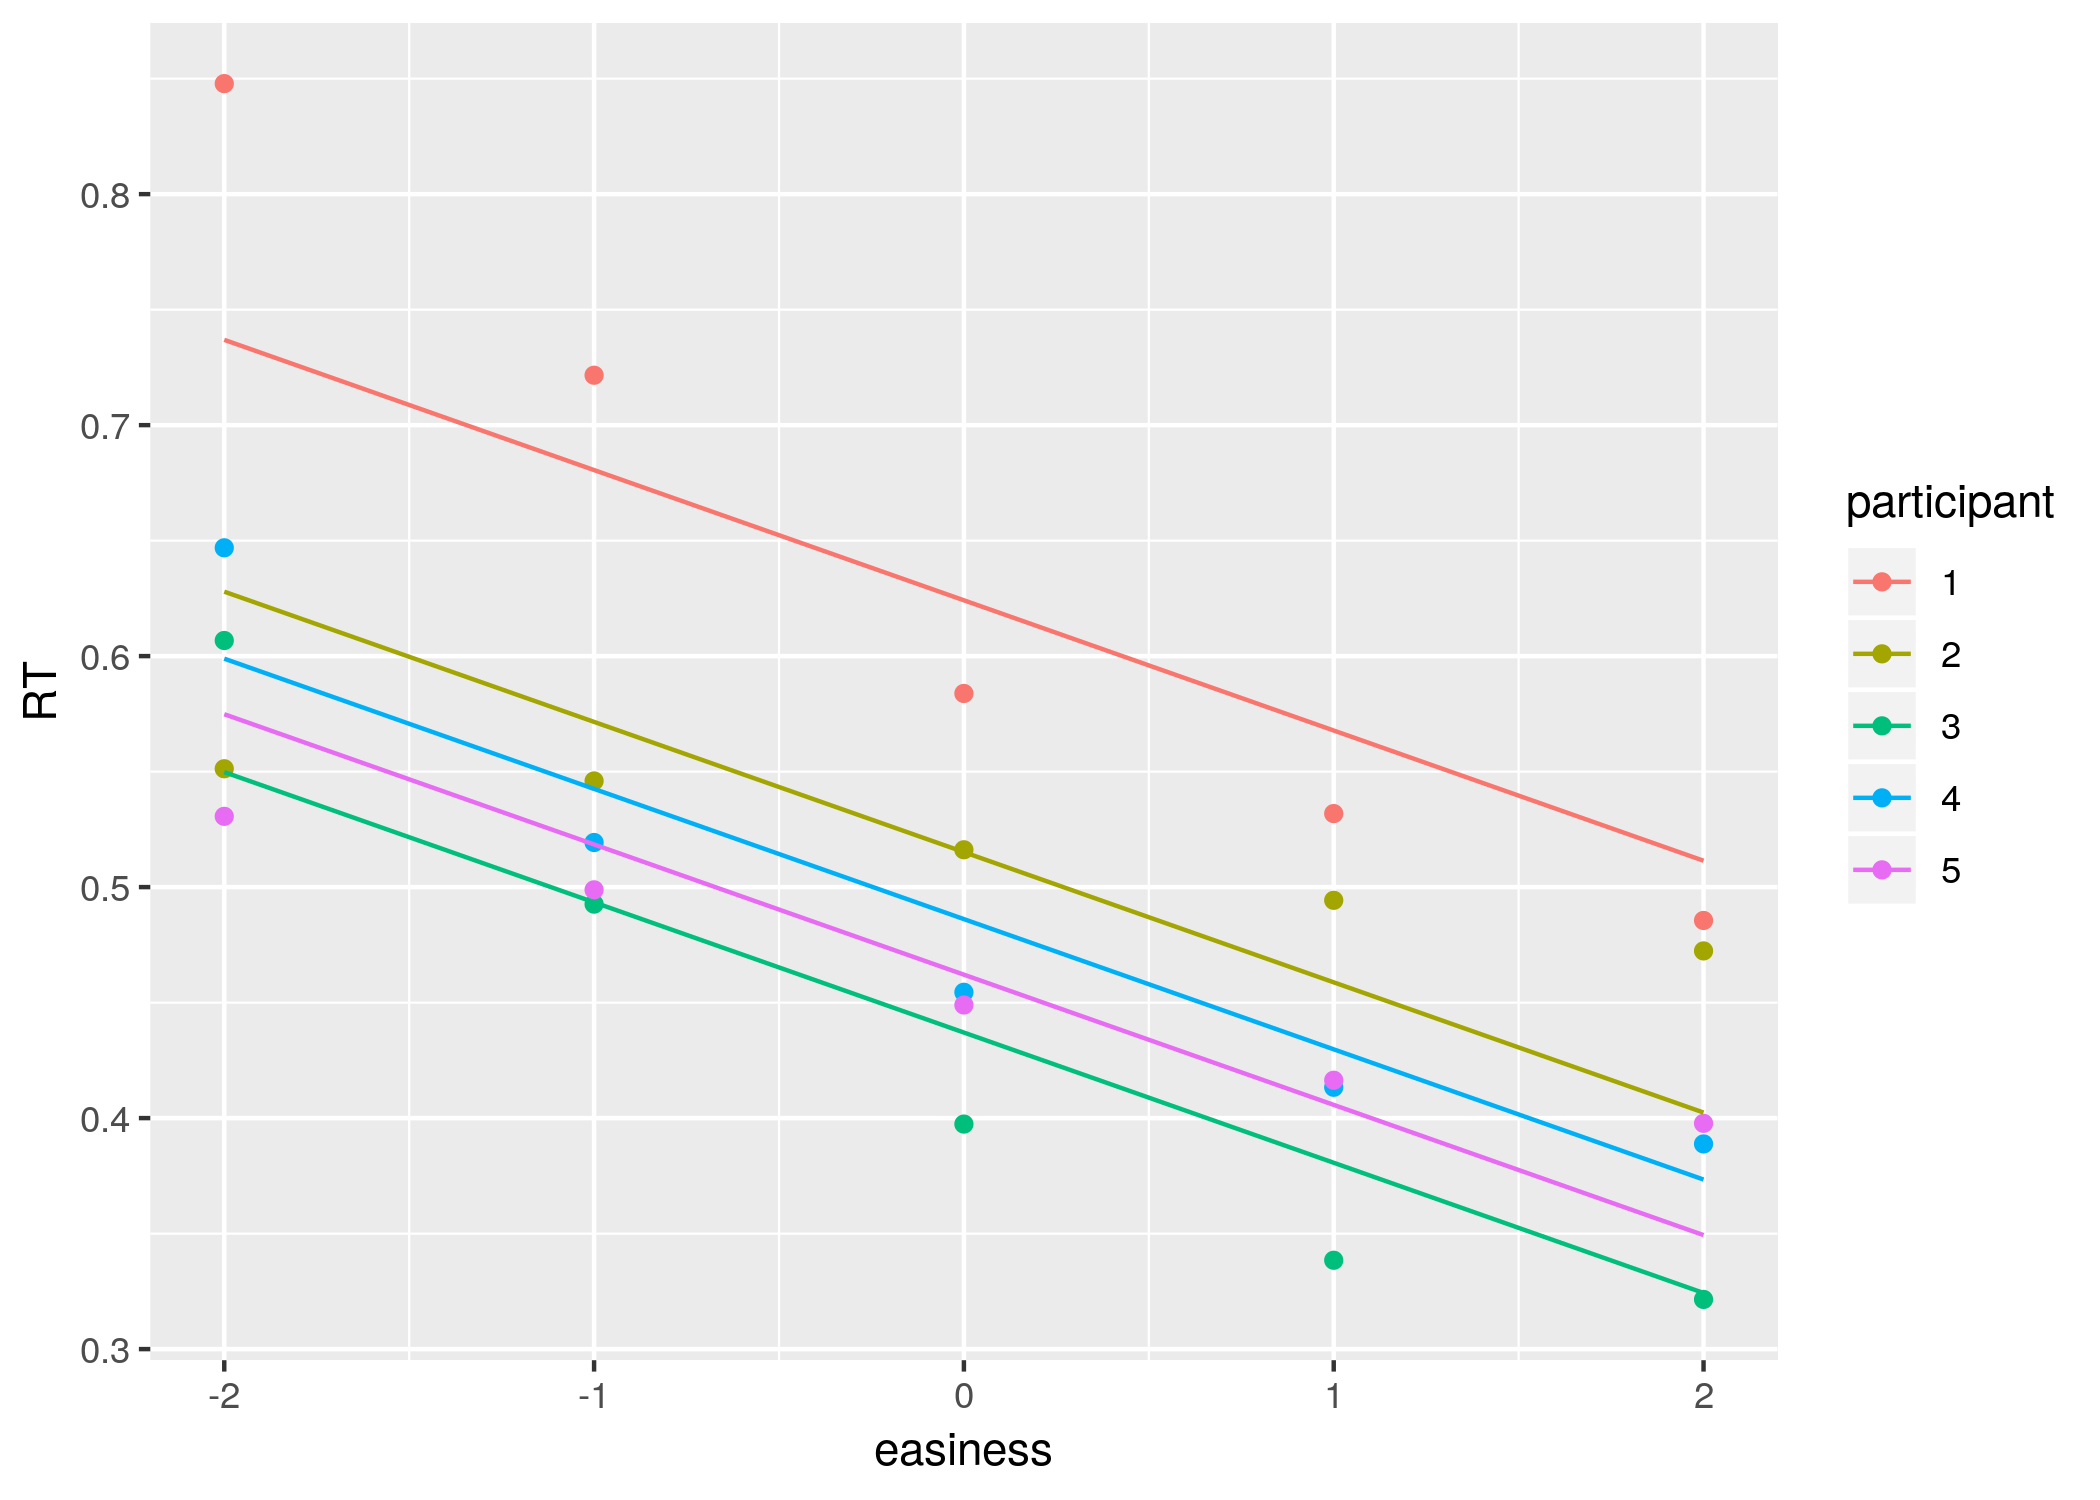

In [6]:
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 300)
ggplot() +
  geom_point(data=means_bysub, aes(x=ease, y=x, group = participant, colour = participant)) + 
  geom_line(data=means_bysub, aes(x=ease, y=random.intercept.preds, group = participant, colour = participant)) +
  labs(x="easiness", y="RT") +
  scale_colour_discrete('participant') 

Now we see that each participant gets attributed an estimated intercept. Additionaly we see a light shrinkage (e.g. participant 3, see later).
But in this model we still assumed that the effect of easiness is the same for everyone, we just released the assumption of same intercept

### A model with random effects on the slope

In [7]:
m2 <- lmer(x ~ ease + (0+ease|participant), data = means_bysub)
means_bysub$random.intercept.preds <- predict(m2)

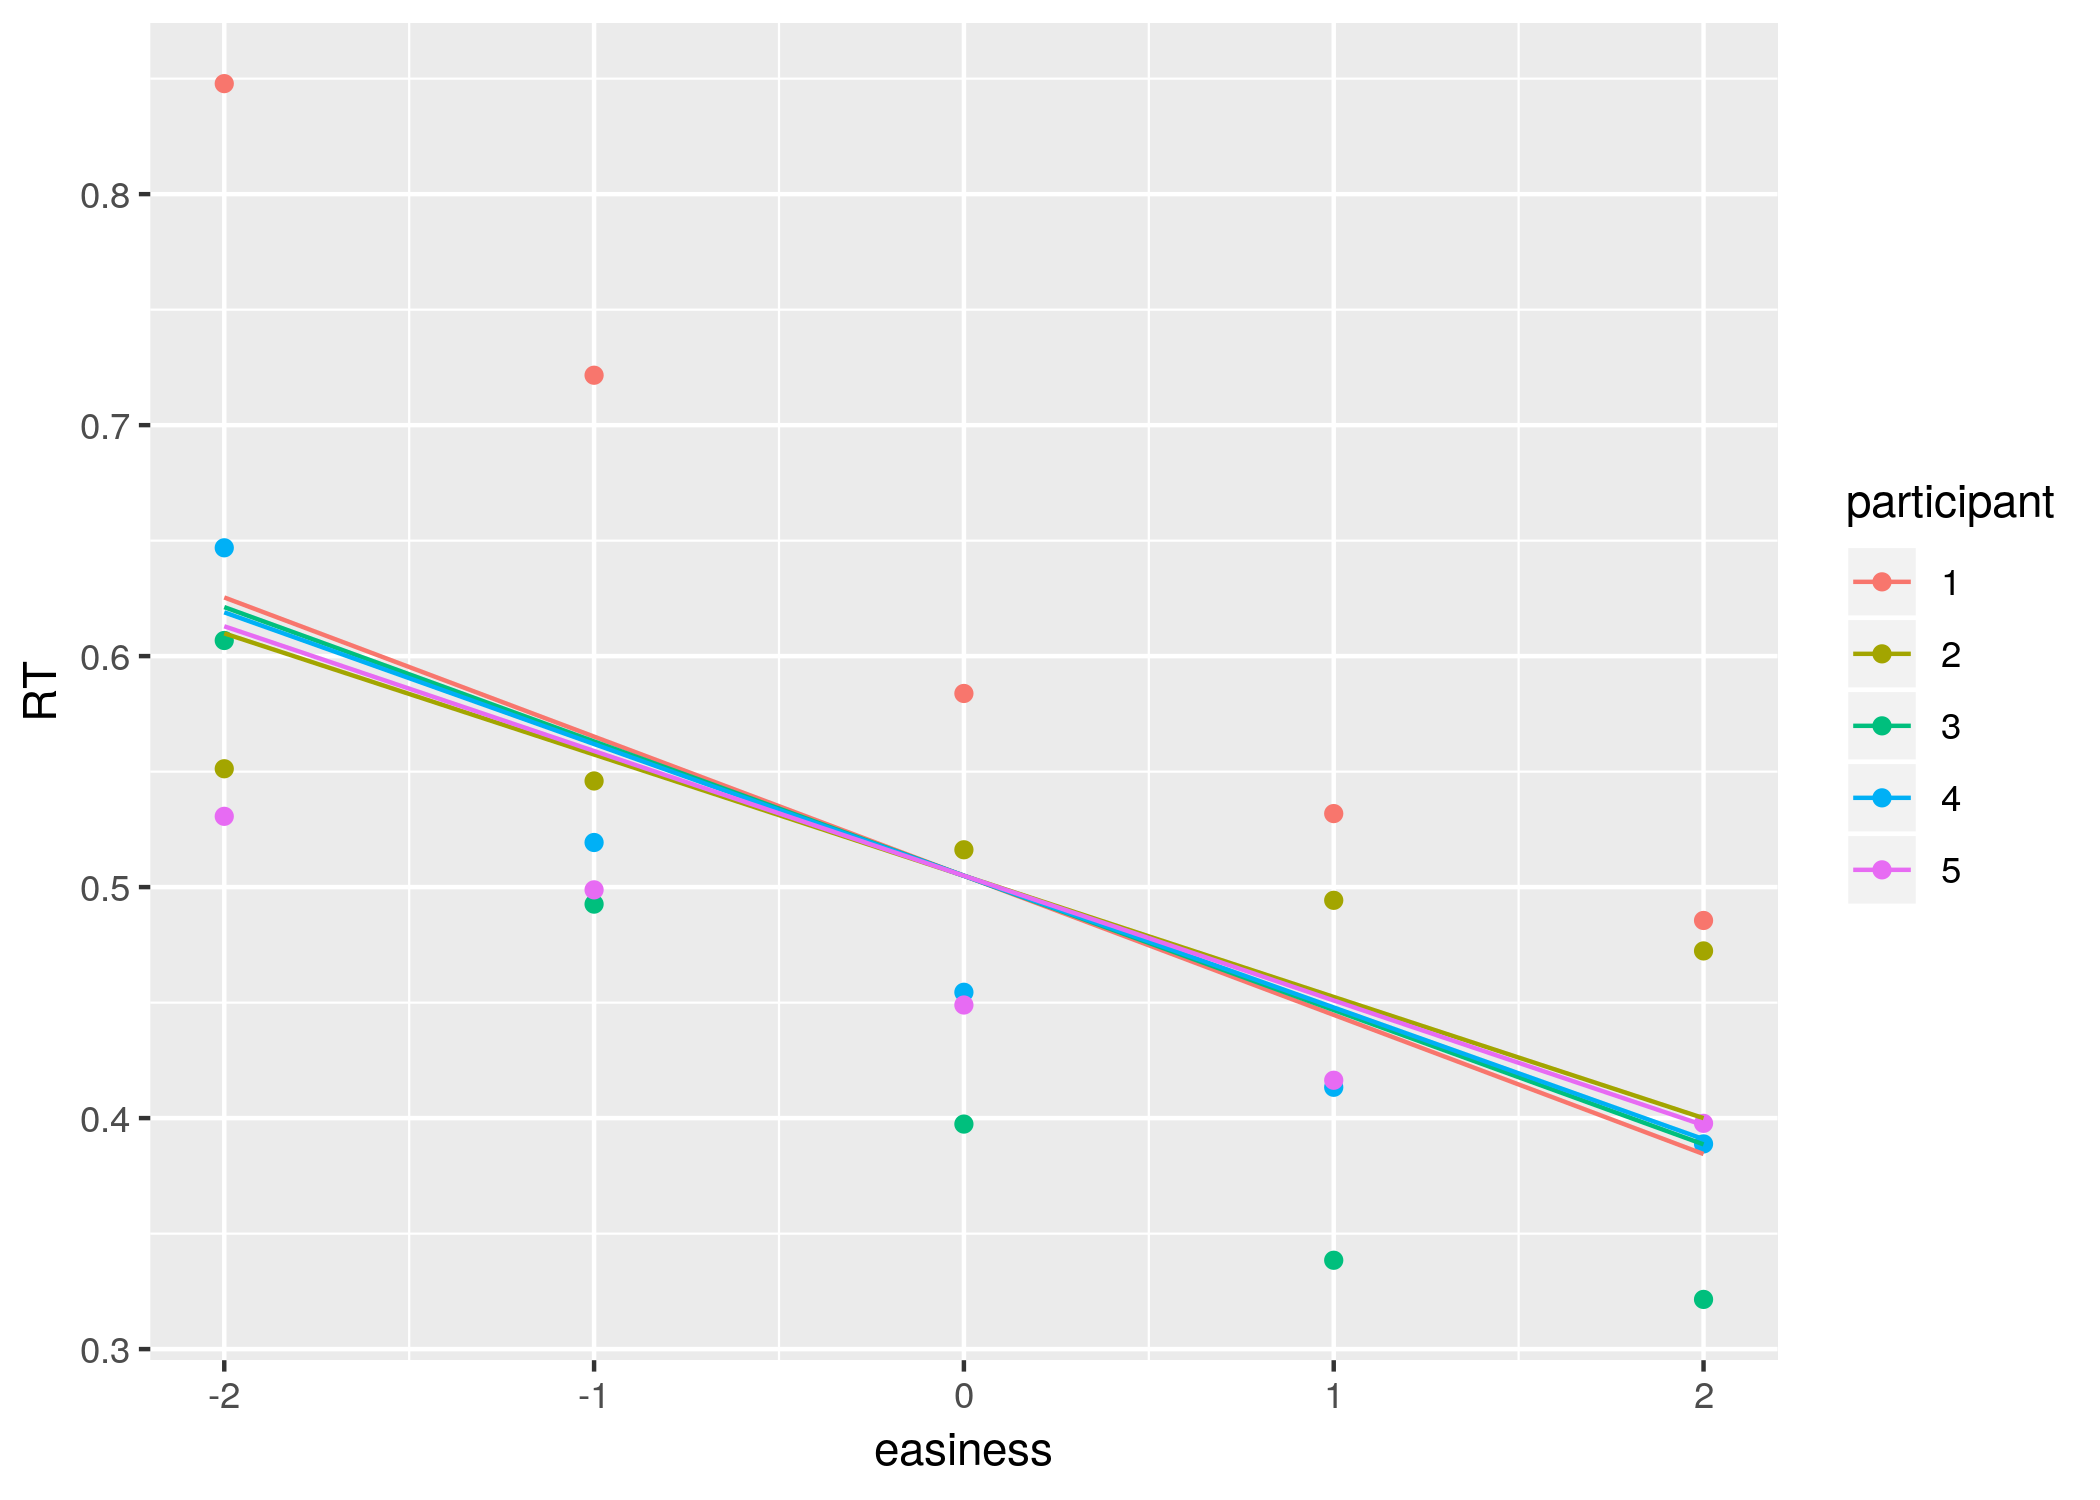

In [8]:
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 300)
ggplot() +
  geom_point(data=means_bysub, aes(x=ease, y=x, group = participant, colour = participant)) + 
  geom_line(data=means_bysub, aes(x=ease, y=random.intercept.preds, group = participant, colour = participant)) +
  labs(x="easiness", y="RT") +
  scale_colour_discrete('participant') 

Now all participants have a slope, but the same intercept. This still doesn't seem to be a very fair assumption

### A model with random effects on the intercept and on the slope

In [9]:
m3 <- lmer(x ~ ease + (1+ease|participant), data = means_bysub)
means_bysub$random.intercept.preds <- predict(m3)

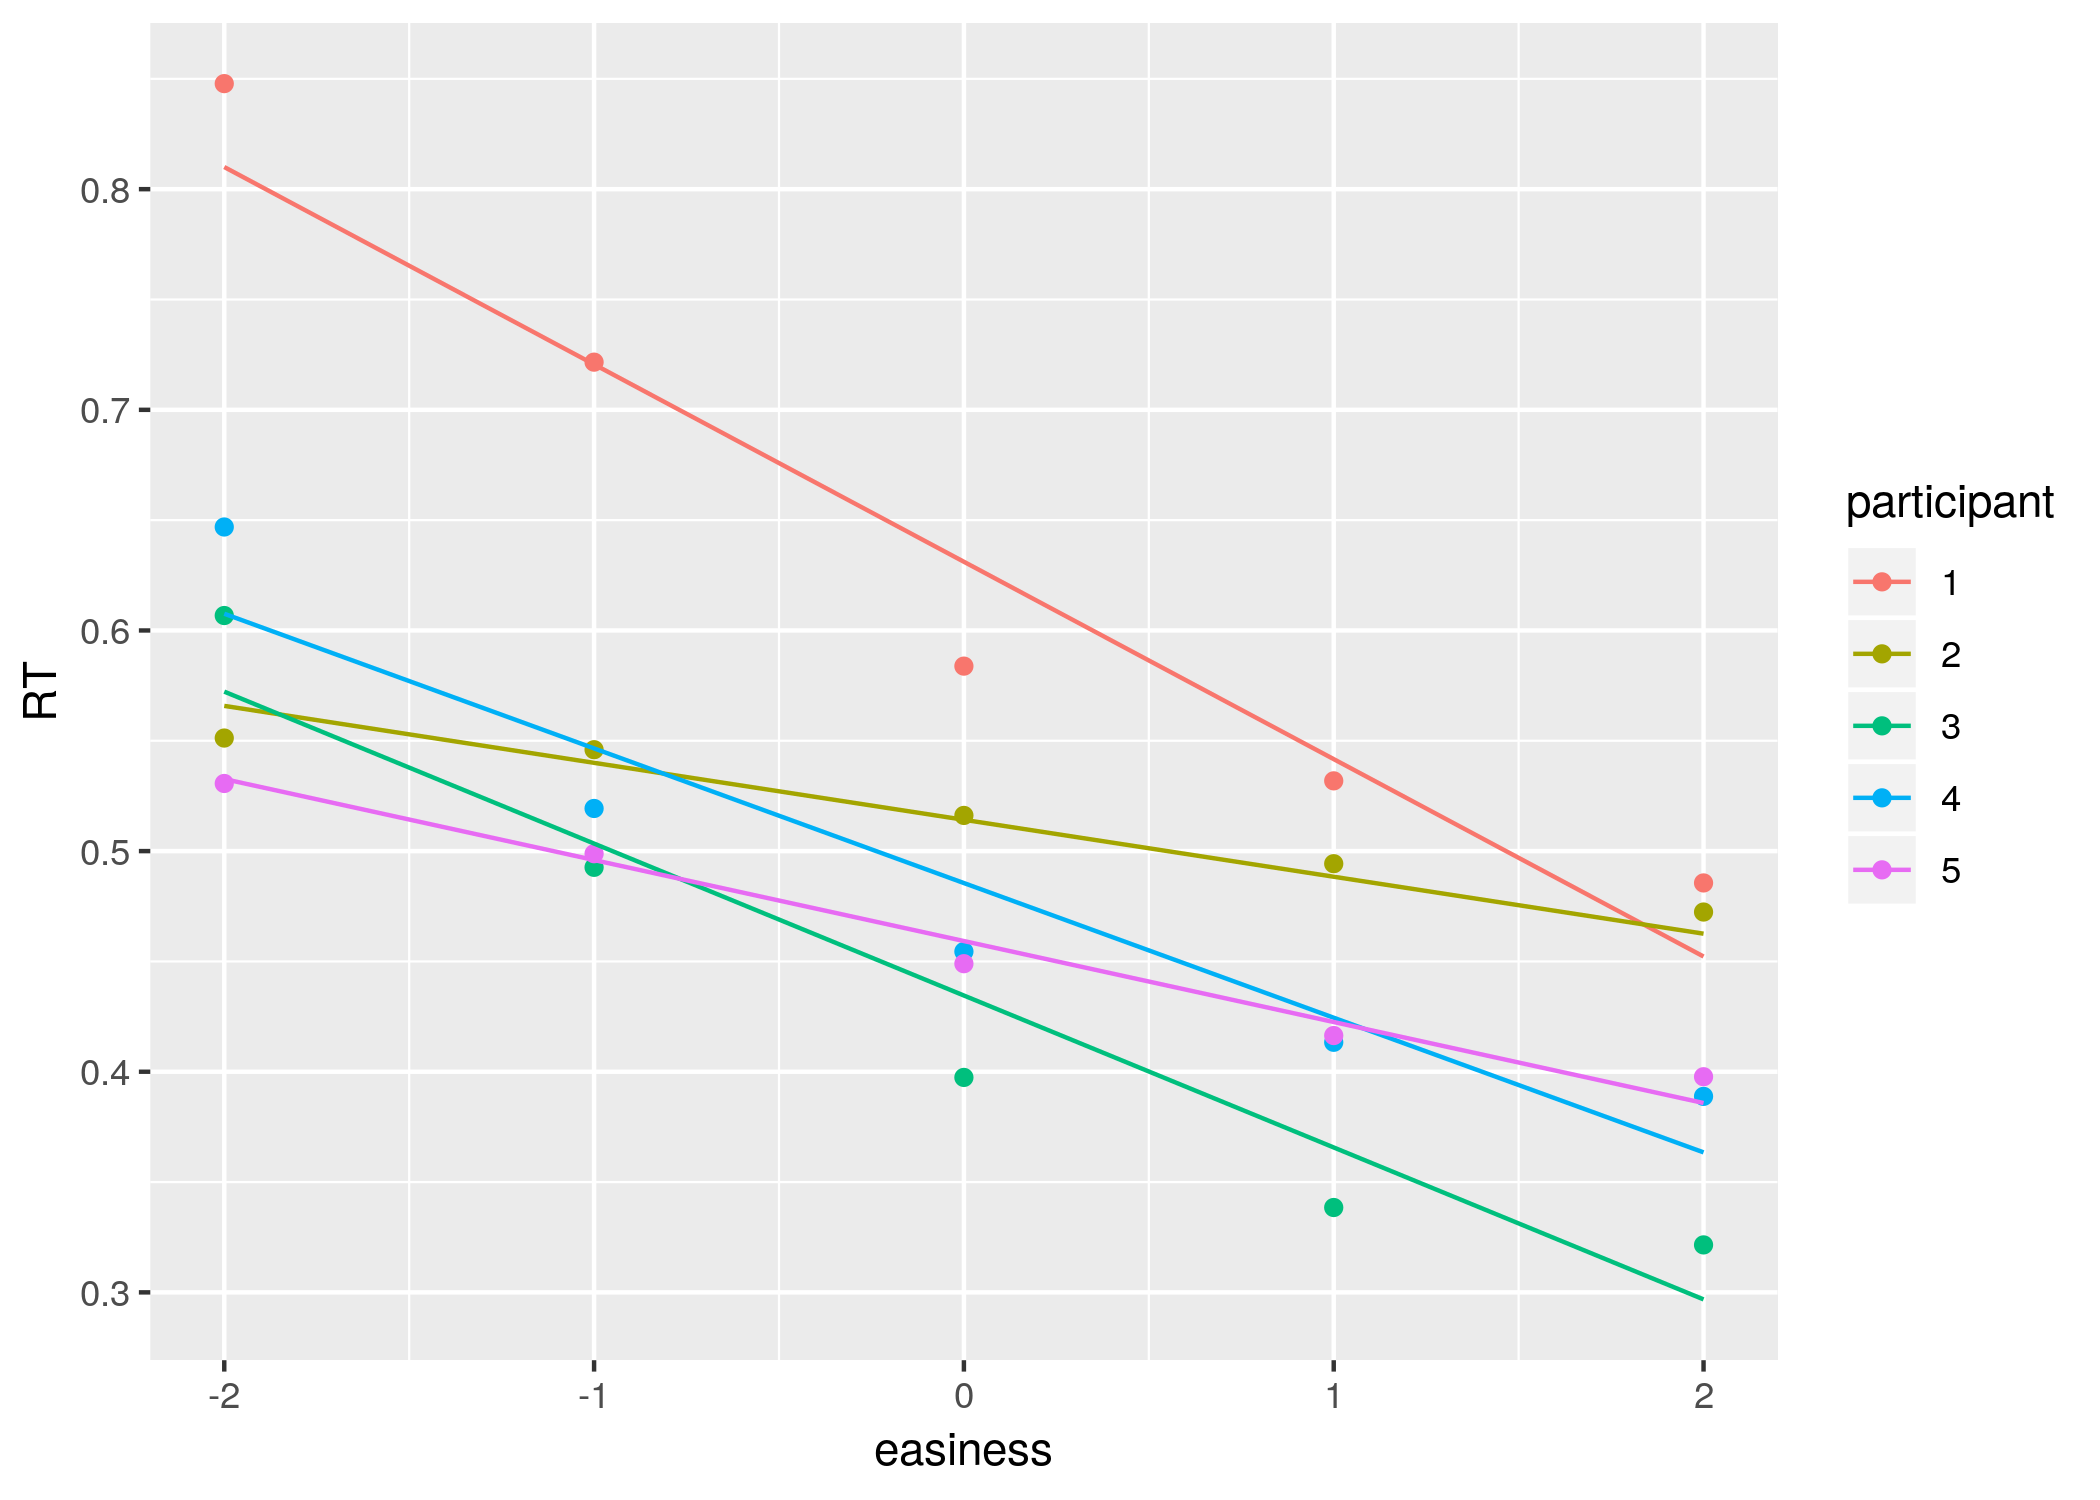

In [10]:
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 300)
ggplot() +
  geom_point(data=means_bysub, aes(x=ease, y=x, group = participant, colour = participant)) + 
  geom_line(data=means_bysub, aes(x=ease, y=random.intercept.preds, group = participant, colour = participant)) +
  labs(x="easiness", y="RT") +
  scale_colour_discrete('participant') 

Now we have random effects on both the intercept and the effect of easiness. The fit does reflect the raw data better than before.

## Comparing the summary() output

In [11]:
summary(m1)

Linear mixed model fit by REML ['lmerMod']
Formula: x ~ ease + (1 | participant)
   Data: means_bysub

REML criterion at convergence: -56.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5673 -0.6474 -0.2684  0.7260  2.2679 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.005721 0.07564 
 Residual                0.002392 0.04891 
Number of obs: 25, groups:  participant, 5

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.504918   0.035212   14.34
ease        -0.056374   0.006917   -8.15

Correlation of Fixed Effects:
     (Intr)
ease 0.000 

In [12]:
summary(m2)

Linear mixed model fit by REML ['lmerMod']
Formula: x ~ ease + (0 + ease | participant)
   Data: means_bysub

REML criterion at convergence: -40.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2753 -0.6902 -0.1701  0.4926  2.6194 

Random effects:
 Groups      Name Variance  Std.Dev.
 participant ease 8.937e-05 0.009454
 Residual         7.212e-03 0.084921
Number of obs: 25, groups:  participant, 5

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.50492    0.01698  29.729
ease        -0.05637    0.01273  -4.428

Correlation of Fixed Effects:
     (Intr)
ease 0.000 

In [13]:
summary(m3)

Linear mixed model fit by REML ['lmerMod']
Formula: x ~ ease + (1 + ease | participant)
   Data: means_bysub

REML criterion at convergence: -67.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.60440 -0.37760  0.03466  0.40459  1.33404 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr 
 participant (Intercept) 0.0060275 0.07764       
             ease        0.0007236 0.02690  -0.46
 Residual                0.0008689 0.02948       
Number of obs: 25, groups:  participant, 5

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.50492    0.03522  14.337
ease        -0.05637    0.01273  -4.428

Correlation of Fixed Effects:
     (Intr)
ease -0.428

Notice that the point estimate of the fixed effects remain the same independent of the random effect structure. However the standard deviation of this fixed, population, effect does vary. How ?

# Illustrating the concept of shrinkage

In [14]:
i_slope_values = NULL
i_intercept_values = NULL
for(i in 1:length(unique(means_bysub$participant))){
    m0_ = lm(x ~ ease, data = means_bysub[means_bysub$participant == i,])
    i_slope_values[i] = m0_$coefficients["ease"]
    i_intercept_values[i] = m0_$coefficients["(Intercept)"]
}


In [15]:
h_slope_values = coef(m3)$participant$ease
h_intercept_values = coef(m3)$participant$'(Intercept)'

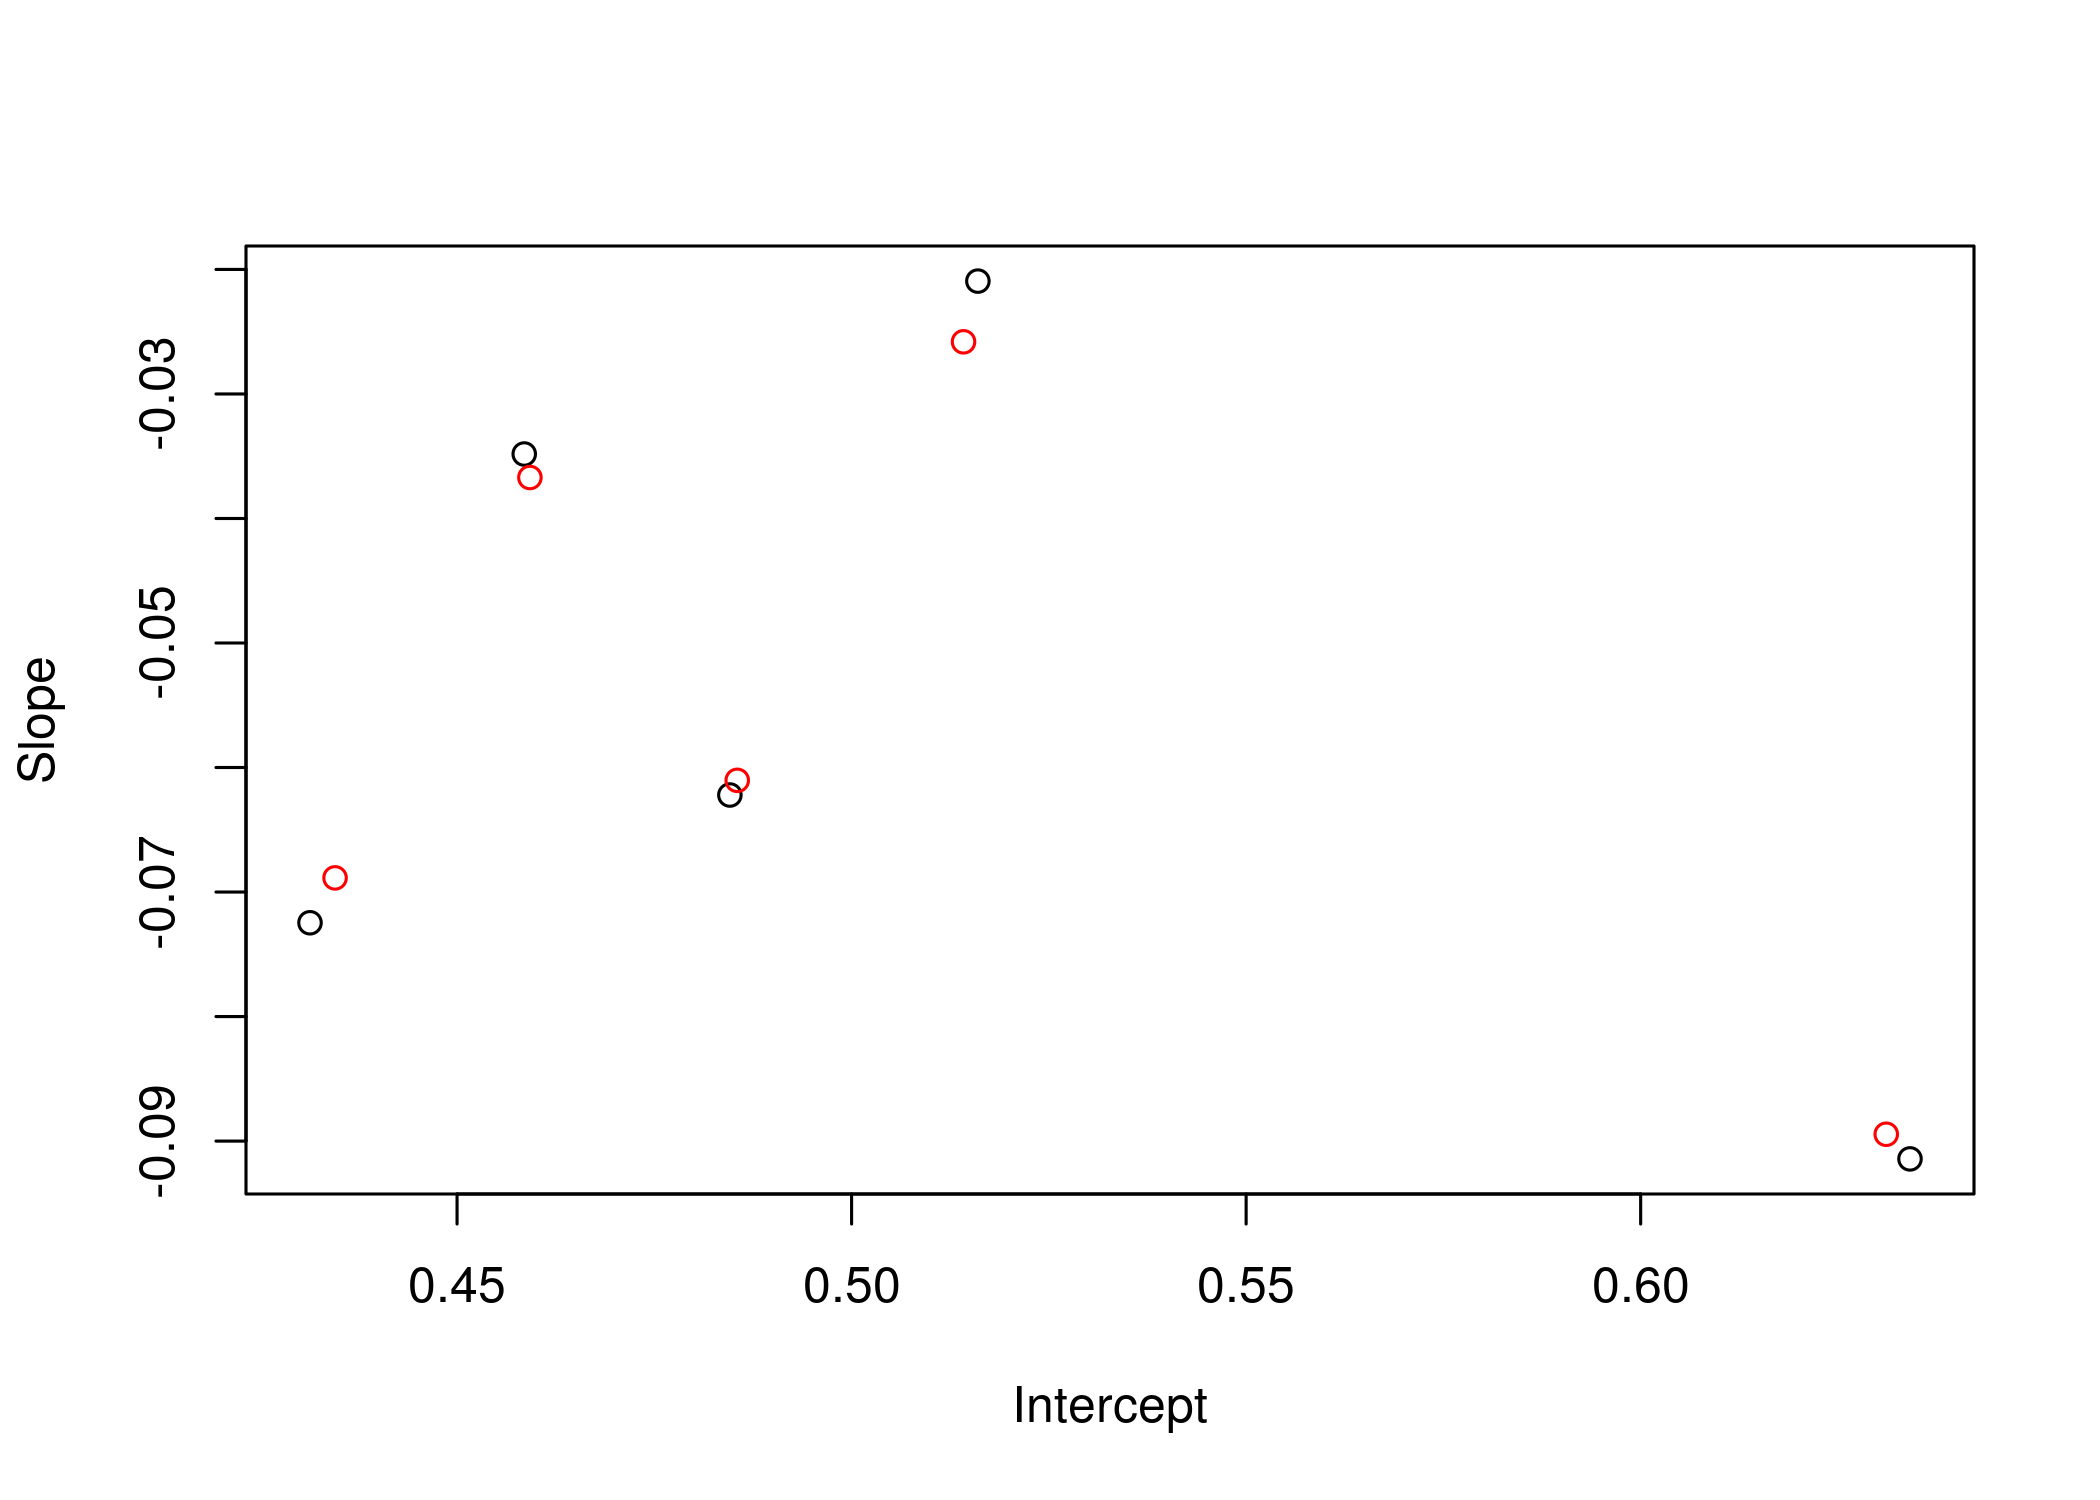

In [16]:
plot(i_intercept_values, i_slope_values, xlab="Intercept", ylab="Slope")
points(h_intercept_values, h_slope_values, col="red")


## Oh... and the assumption of our model ??

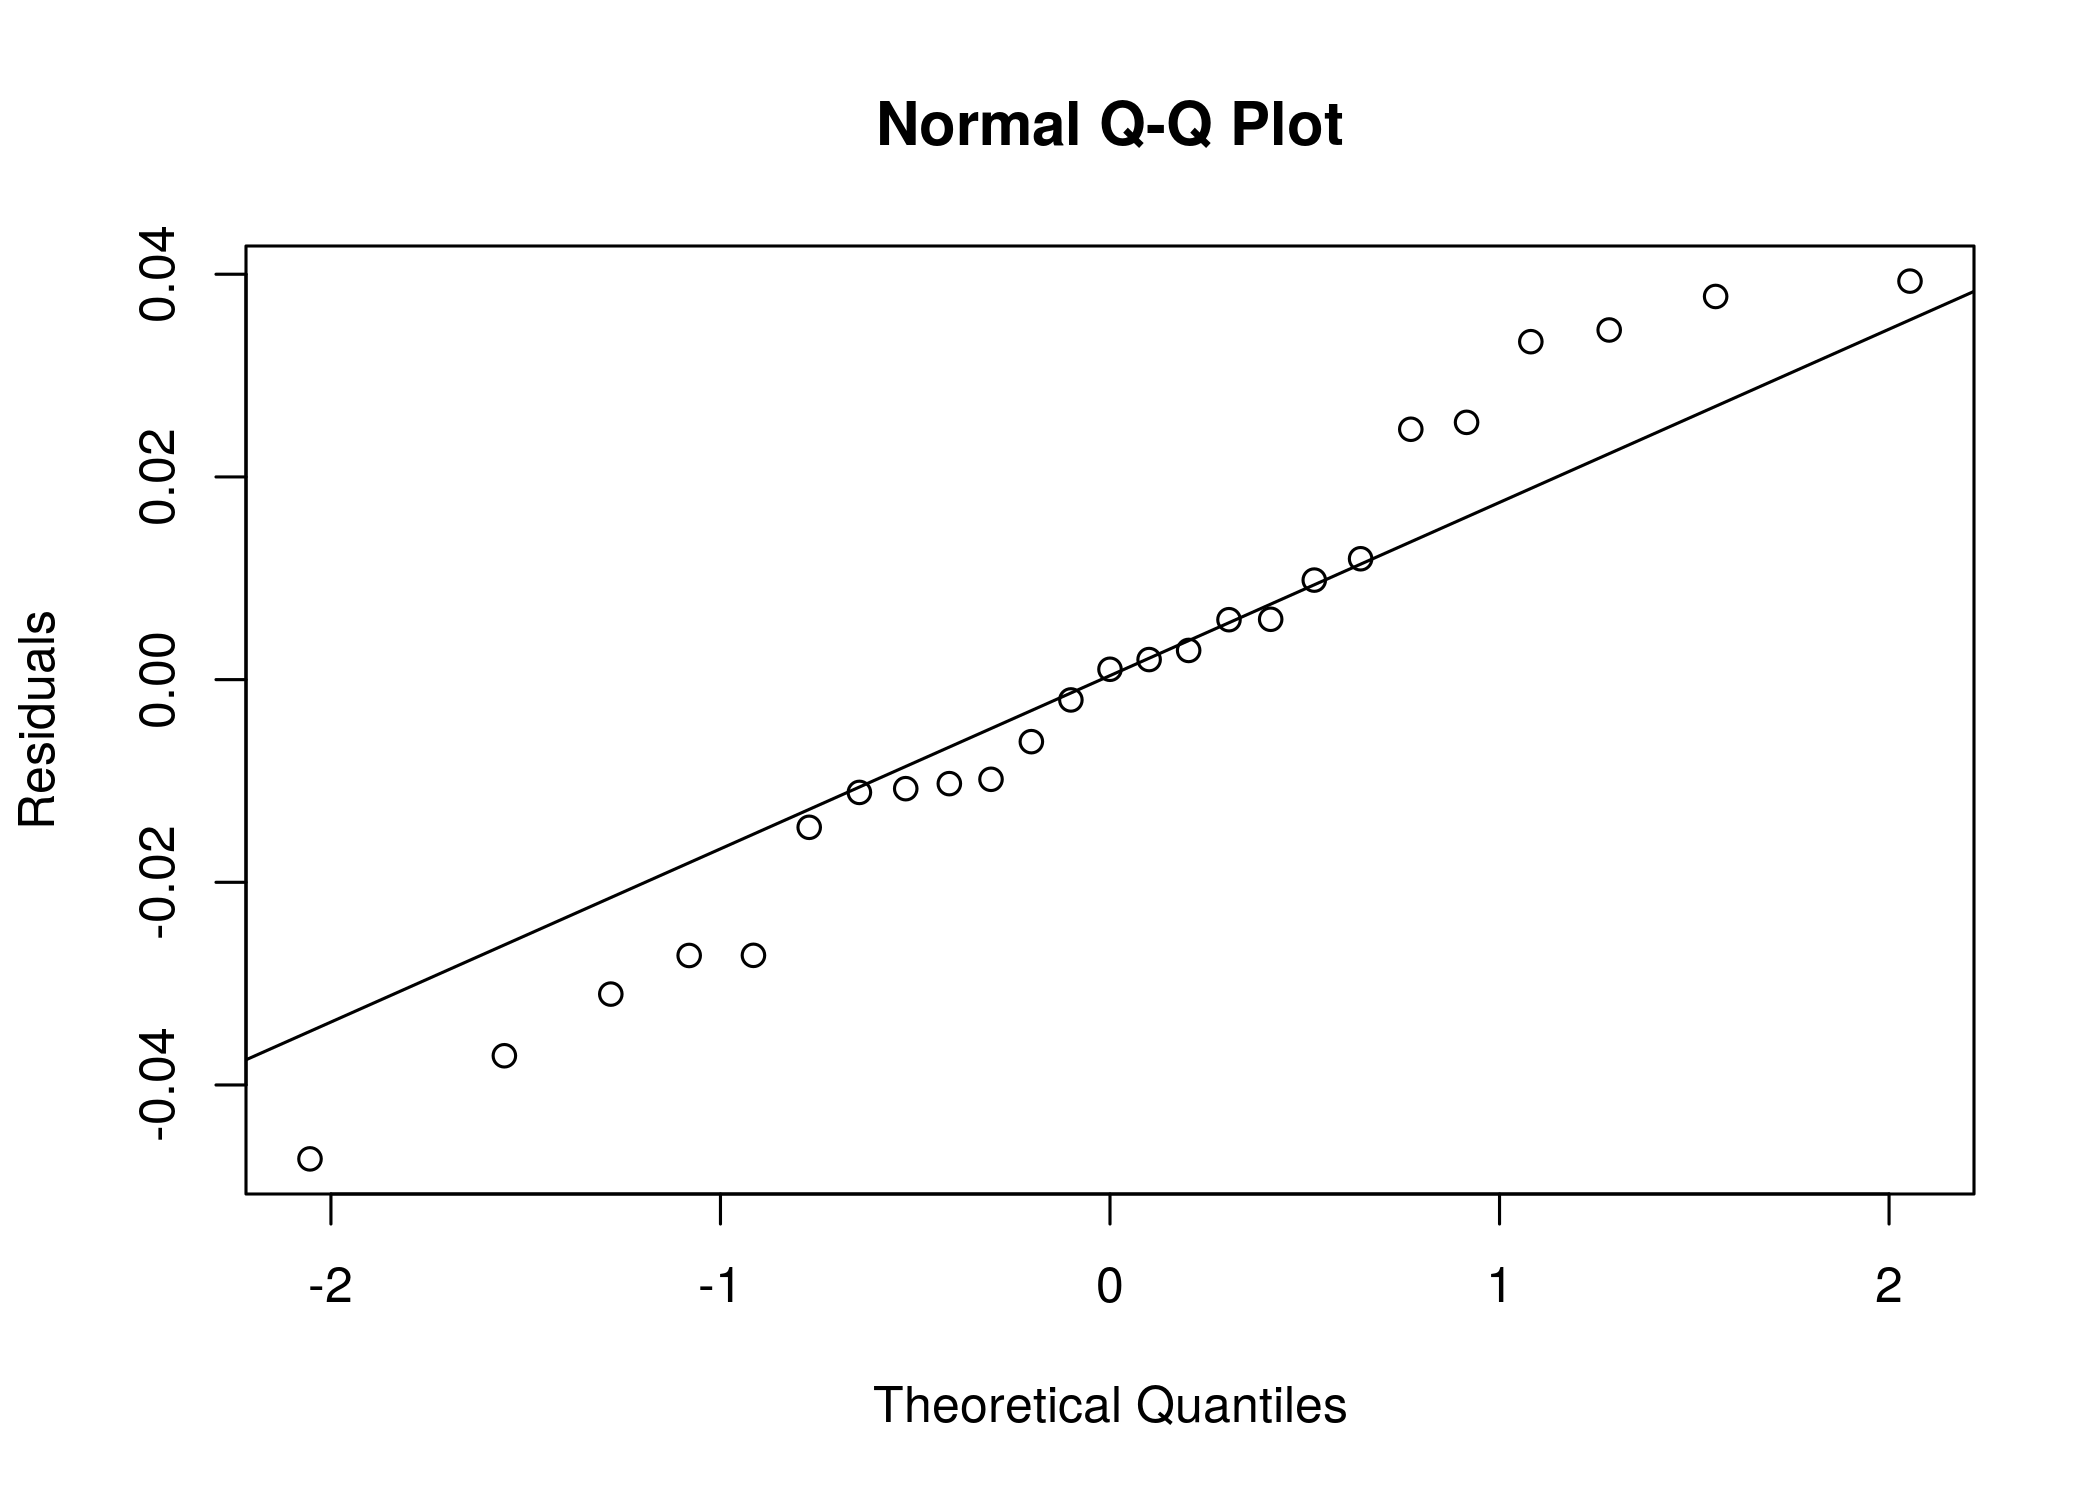

In [17]:
qqnorm(residuals(m3), ylab="Residuals")
qqline(residuals(m3))

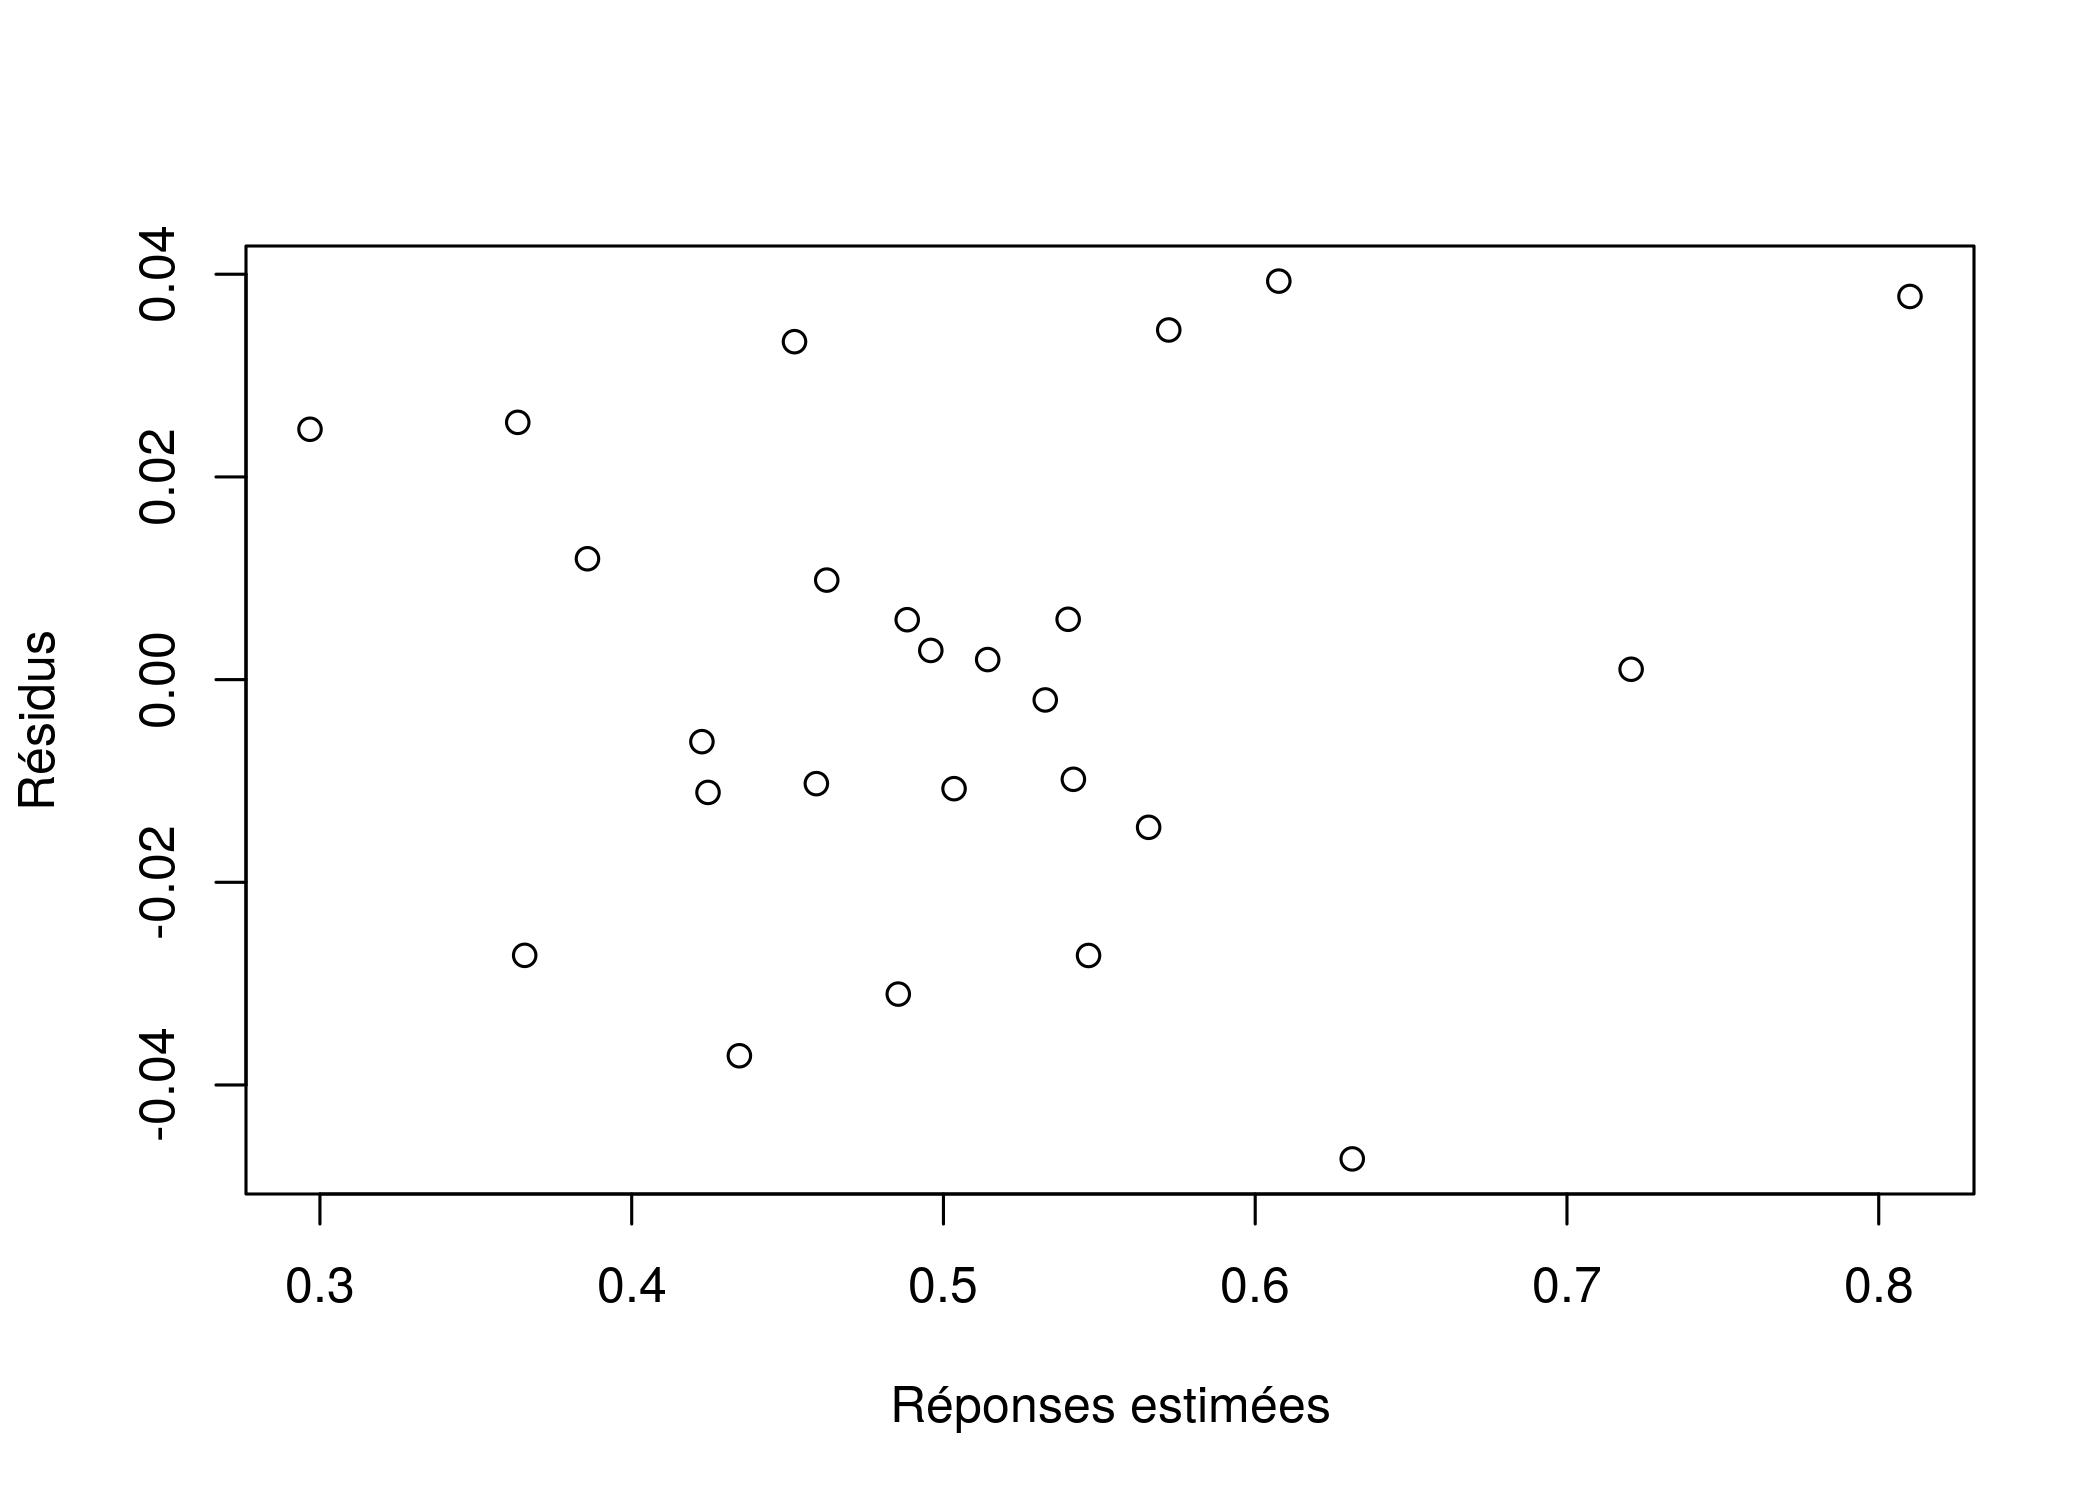

In [18]:
plot(fitted(m3),resid(m3),main="",xlab="Réponses estimées",ylab="Résidus")

# Exercice

- Reproduce the linear model from the previous section with only the easiness predictor and the same subsampled data 
```data[(data$participant < 6) & (data$encoding == "standard"),]```
- Compare the summary between the simple linear model and the last mixed model (M3)